# Energy of a Fermi Gas in a Cubic Box

## Objective
We numerically investigate the total energy of a non-interacting Fermi gas confined to a cubic box in the grand canonical ensemble. Using the Fermi–Dirac distribution and the discrete quantum energy levels of a particle in a box, we compute the total energy as a function of the box size \(L\) for three temperature regimes:

$
\beta\mu = 10,\; 1,\; 0.1.
$

We test the expected finite-size scaling law:

$
E(L) = \rho_E L^3 + 6\sigma_E L^2 + \delta E,
$

and extract the bulk energy density \(\rho_E\), surface energy density \(\sigma_E\), and the residual finite-size correction \(\delta E\).

## Theoretical Background

For a fermion of mass ($m$) confined to a cubic box of side length ($L$), the single-particle energy levels are

$
\epsilon_{\vec{n}} = \frac{\pi^2\hbar^2}{2mL^2}
\left(n_x^2 + n_y^2 + n_z^2\right),
\quad n_i \in \mathbb{Z}^+.
$

In the grand canonical ensemble, the mean occupation number of each energy level is given by the Fermi–Dirac distribution:

$
f_+(\epsilon) = \frac{1}{e^{\beta(\epsilon-\mu)} + 1},
$

where ($\beta = 1/(k_BT)$) and ($\mu$) is the chemical potential.

The total particle number and total energy are therefore:

$
N = \sum_{\vec n} f_+(\epsilon_{\vec n}), \qquad
E = \sum_{\vec n} \epsilon_{\vec n}\, f_+(\epsilon_{\vec n}).
$

For large system size ($L$), the total energy is expected to scale as:

$
E(L) = \rho_E L^3 + 6\sigma_E L^2 + \delta E,
$

where \(\rho_E\) is the bulk energy density, ($\sigma_E$) is the surface energy density, and ($\delta E$) represents higher-order finite-size corrections.

The factor of 6 multiplying the surface term arises from the geometry of the cubic box. A cube of side length \(L\) has total surface area:

$
A = 6L^2,
$

corresponding to its six faces. The coefficient ($\sigma_E$) therefore represents the energy per unit surface area, and the total surface contribution to the energy is:

$
E_{\text{surface}} = \sigma_E A = 6\sigma_E L^2.
$


## Numerical Method

All calculations were performed in dimensionless units by setting \(\hbar = m = 1\), so that

$
\epsilon_{\vec n} = C \frac{n_x^2 + n_y^2 + n_z^2}{L^2},
\qquad C = \frac{\pi^2}{2}.
$

The numerical evaluation of the total energy was carried out as follows:

1. An energy cutoff
$
\epsilon_{\text{cut}} = \mu + \frac{\alpha}{\beta}
$
was introduced.

2. The maximum quantum number ($n_{\max}$) was determined from ($\epsilon_{\text{cut}}$).

3. All integer triples ($n_x,n_y,n_z$) with ($n_i \ge 1$) were enumerated.

4. States with equal values of
$
n^2 = n_x^2 + n_y^2 + n_z^2
$
were grouped using multiplicities.

5. The energy was evaluated as
$
E = \sum_{n^2} \epsilon(n^2)\, f_+(\epsilon)\, g(n^2),
$
where ($g(n^2)$) is the degeneracy.

The cutoff was increased until numerical convergence of the energy was achieved. Because the surface area of a cube is ($A = 6L^2$), the intercept of the linear fit corresponds to ($6\sigma_E$), and therefore ($\sigma_E$) is obtained by dividing the intercept by 6.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit

In [5]:
# --------------------------
# Parameters
# --------------------------
hbar = 1.0   # set to 1 for convenience (rescale later if desired)
m = 1.0      # set to 1
C = (hbar**2 * np.pi**2) / (2.0 * m)   # prefactor in eps = C * n^2 / L^2

mu = 1.0                              # chemical potential (choose units consistent with C)
beta_values = [10.0, 1.0, 0.1]        # gives beta*mu = 10, 1, 0.1 when mu=1
L_values = np.linspace(5.0, 30.0, 12) # you can change spacing or range
alpha_cut = 12.0                      # number of kT above mu to include (thermal cutoff parameter)
convergence_tol = 1e-6                # optional convergence tolerance on E when raising cutoff

In [6]:
# --------------------------
# Fermi-Dirac Distribution
# --------------------------
def fermi_dirac_stable(x):
    # x = beta*(eps - mu). Vectorized.
    # For large positive x => occupation ~ 0
    # For large negative x => occupation ~ 1
    # Only compute exp(x) when x is moderate.
    out = np.empty_like(x, dtype=float)
    out[:] = 0.0
    mask_high = x > 50.0
    mask_low = x < -50.0
    mask_mid = ~(mask_high | mask_low)
    out[mask_high] = 0.0
    out[mask_low] = 1.0
    out[mask_mid] = 1.0 / (np.exp(x[mask_mid]) + 1.0)
    return out

In [7]:
# --------------------------
# Compute energy using multiplicity grouping
# --------------------------
def compute_energy_with_multiplicity(L, mu, beta, alpha=alpha_cut):
    """
    Compute total energy for a cube of side L by:
      - choosing eps_cut = mu + alpha/beta
      - computing nmax from eps_cut
      - enumerating integer triples 1..nmax, grouping by n^2 multiplicity
      - summing eps * f(eps) * multiplicity
    Returns total_energy, nmax
    """
    eps_cut = mu + alpha / beta

    # minimal n^2 is 1^2+1^2+1^2 = 3
    # invert eps = C * n^2 / L^2 => n^2_max = eps_cut * L^2 / C
    n2_max = eps_cut * (L**2) / C
    nmax = max(1, int(np.floor(np.sqrt(n2_max))) )  # at least 1, but we will add some safety margin
    # add small safety margin to ensure we include near-cutoff states
    nmax += 2

    # Build 3D n^2 array vectorized if not too large.
    # Check memory: (nmax)^3 should be manageable for nmax ~ up to few hundreds.
    n = np.arange(1, nmax + 1, dtype=int)
    n2 = n**2

    # build 3d nsq array using broadcasting, then flatten and bincount multiplicity
    # nsq = nx2[:,None,None] + ny2[None,:,None] + nz2[None,None,:]
    nx2 = n2[:, None, None]    # shape (nmax,1,1)
    ny2 = n2[None, :, None]    # shape (1,nmax,1)
    nz2 = n2[None, None, :]    # shape (1,1,nmax)
    nsq_3d = nx2 + ny2 + nz2   # shape (nmax,nmax,nmax)
    nsq_flat = nsq_3d.ravel()
    max_nsq = int(nsq_flat.max())
    counts = np.bincount(nsq_flat)  # counts[k] = multiplicity of n^2 == k; index 0..max_nsq

    # Consider only n^2 >= 3 because nx,ny,nz >=1 produces minimum 3; counts[0..2] will be zero
    # Build array of n2_values and multiplicities where multiplicity > 0
    n2_values = np.nonzero(counts)[0]   # indices where count>0
    multiplicities = counts[n2_values]

    # compute eps for each distinct n^2
    eps_values = C * n2_values / (L**2)   # vector
    x = beta * (eps_values - mu)
    occ = fermi_dirac_stable(x)           # occupation for each n^2

    # energy sum: sum_over_n2 [ eps(n2) * occ(n2) * multiplicity(n2) ]
    E_total = np.sum(eps_values * occ * multiplicities)

    return float(E_total), nmax

In [8]:
def compute_energy_converged(L, mu, beta, alphas=[8,12,16]):
    """
    Try several alpha values and check convergence of E.
    Returns energy computed with the largest alpha and the sequence of energies.
    """
    E_list = []
    nmax_list = []
    for a in alphas:
        E, nmax = compute_energy_with_multiplicity(L, mu, beta, alpha=a)
        E_list.append(E)
        nmax_list.append(nmax)
    return E_list[-1], nmax_list[-1], E_list, nmax_list

In [9]:
# --------------------------
# Main loop: compute energies for each beta and L
# --------------------------
results = {}
for beta in beta_values:
    Evals = []
    nmax_vals = []
    for L in L_values:
        E, nmax, E_history, nmax_history = compute_energy_converged(L, mu, beta, alphas=[8,12,16])
        Evals.append(E)
        nmax_vals.append(nmax)
    results[beta] = {"L": np.array(L_values), "E": np.array(Evals), "nmax": np.array(nmax_vals)}

## Results and Finite-Size Scaling

For each temperature regime, the total energy was computed for 12 values of the box size in the range
$
L \in [5,30].
$

To extract the bulk and surface contributions, the quantity ($E/L^2$) was plotted as a function of ($L$). Dividing the finite-size expansion by ($L^2$) gives:

$
\frac{E}{L^2} = \rho_E L + 6\sigma_E + \frac{\delta E}{L^2}.
$

Thus, a linear fit of ($E/L^2$) versus ($L$) yields the bulk energy density ($\rho_E$) as the slope and ($6\sigma_E$) as the intercept. The surface energy density ($\sigma_E$) is obtained by dividing the fitted intercept by 6.

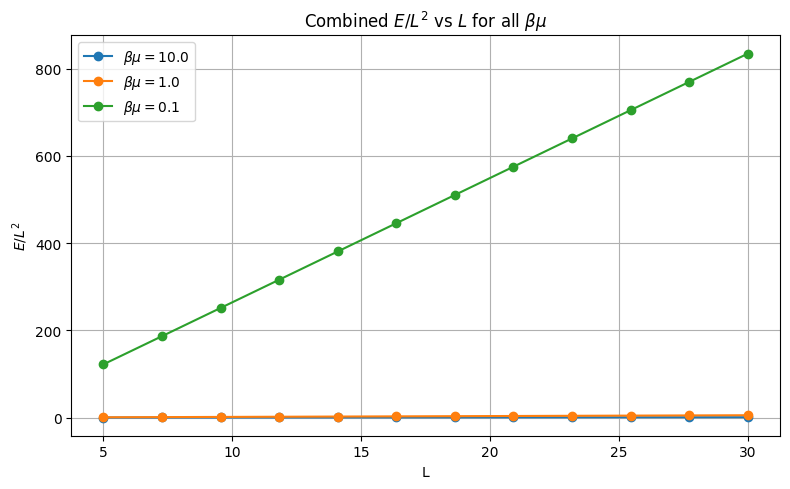


========= SUMMARY TABLE =========
 beta*mu    rho_E (slope)     sigma_E (intercept/6)    max|deltaE|
  10.000   2.99580920e-02   -1.78773410e-02   1.474194e+00
   1.000   1.89430731e-01   -6.51929057e-02   5.177327e+00
   0.100   2.84944765e+01   -3.44749113e+00   8.598192e+01


In [15]:
# --------------------------
# Fit E/L^2 vs L, plot combined, print rho,sigma,delta
# --------------------------
plt.figure(figsize=(8,5))
for beta in beta_values:
    L = results[beta]["L"]
    E = results[beta]["E"]
    y = E / (L**2)

    # linear fit: y = intercept + slope * L    (intercept = 6*sigma_E, slope = rho_E)
    coefs = polyfit(L, y, 1)   # returns [c0 (intercept), c1 (slope)]
    intercept = coefs[0]
    rho_E = coefs[1]
    sigma_E = intercept / 6.0

    # reconstruct fitted energy and deltaE
    E_fit = rho_E * L**3 + 6.0 * sigma_E * L**2
    deltaE = E - E_fit
    deltaE_max = np.max(np.abs(deltaE))

    # store
    results[beta].update({
        "rho_E": rho_E,
        "sigma_E": sigma_E,
        "E_fit": E_fit,
        "deltaE": deltaE,
        "deltaE_max": deltaE_max
    })

    plt.plot(L, y, marker='o', linestyle='-', label=rf"$\beta\mu={beta*mu}$")

plt.xlabel("L")
plt.ylabel(r"$E/L^2$")
plt.title(r"Combined $E/L^2$ vs $L$ for all $\beta\mu$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# summary table
print("\n========= SUMMARY TABLE =========")
print(" beta*mu    rho_E (slope)     sigma_E (intercept/6)    max|deltaE|")
for beta in beta_values:
    print(f"{beta*mu:8.3f}   {results[beta]['rho_E']:14.8e}   {results[beta]['sigma_E']:14.8e}   {results[beta]['deltaE_max']:12.6e}")
print("=================================")


### Individual Graphs/Results

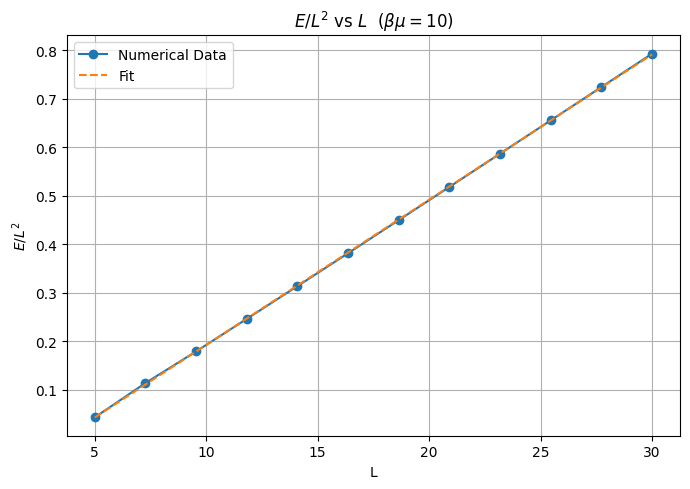

RESULTS FOR  beta*mu = 10
rho_E   = 2.9958091960e-02
sigma_E = -1.7877340954e-02
   L         E            E_fit         deltaE
 5.000  1.070101e+00  1.063160e+00   6.941025e-03
 7.273  6.006905e+00  5.850604e+00   1.563012e-01
 9.545  1.630002e+01  1.628234e+01   1.768314e-02
11.818  3.436263e+01  3.446848e+01  -1.058446e-01
14.091  6.224646e+01  6.251915e+01  -2.726862e-01
16.364  1.021531e+02  1.025445e+02  -3.913642e-01
18.636  1.562083e+02  1.566546e+02  -4.462353e-01
20.909  2.265631e+02  2.269595e+02  -3.964863e-01
23.182  3.153574e+02  3.155695e+02  -2.121306e-01
25.455  4.247344e+02  4.245947e+02   1.397068e-01
27.727  5.568361e+02  5.561451e+02   6.910122e-01
30.000  7.138050e+02  7.123308e+02   1.474194e+00
max |deltaE| = 1.474194e+00


In [11]:
beta = 10.0   # beta*mu = 10

L = results[beta]["L"]
E = results[beta]["E"]
y = E / (L**2)

rho_E   = results[beta]["rho_E"]
sigma_E = results[beta]["sigma_E"]
E_fit   = results[beta]["E_fit"]
deltaE = results[beta]["deltaE"]

y_fit = rho_E * L + 6.0 * sigma_E

plt.figure(figsize=(7,5))
plt.plot(L, y, marker='o', linestyle='-', label="Numerical Data")
plt.plot(L, y_fit, linestyle='--', label="Fit")
plt.xlabel("L")
plt.ylabel(r"$E/L^2$")
plt.title(r"$E/L^2$ vs $L$  ($\beta\mu=10$)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("==============================================")
print("RESULTS FOR  beta*mu = 10")
print("==============================================")
print(f"rho_E   = {rho_E:.10e}")
print(f"sigma_E = {sigma_E:.10e}")
print("   L         E            E_fit         deltaE")

for Li, Ei, Efi, dEi in zip(L, E, E_fit, deltaE):
    print(f"{Li:6.3f}  {Ei:12.6e}  {Efi:12.6e}  {dEi: .6e}")

print(f"max |deltaE| = {results[beta]['deltaE_max']:.6e}")

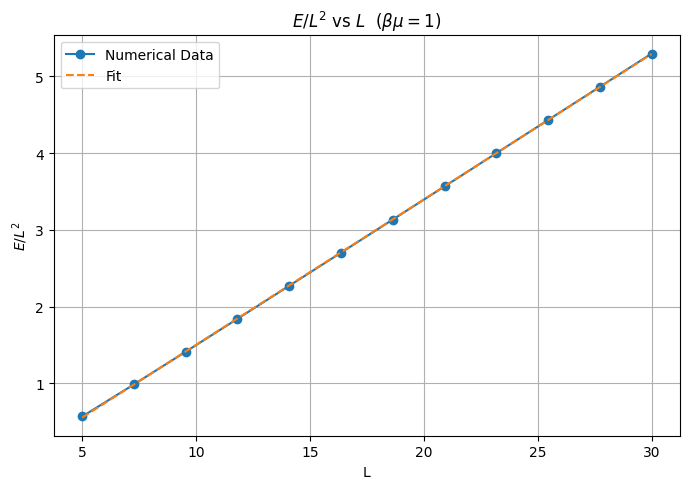

RESULTS FOR  beta*mu = 1
rho_E   = 1.8943073146e-01
sigma_E = -6.5192905739e-02
   L         E            E_fit         deltaE
 5.000  1.423513e+01  1.389991e+01   3.352266e-01
 7.273  5.226168e+01  5.217960e+01   8.208007e-02
 9.545  1.288153e+02  1.291151e+02  -2.997425e-01
11.818  2.573278e+02  2.580489e+02  -7.211311e-01
14.091  4.512310e+02  4.523240e+02  -1.092959e+00
16.364  7.239568e+02  7.252829e+02  -1.326124e+00
18.636  1.088937e+03  1.090268e+03  -1.331512e+00
20.909  1.559603e+03  1.560623e+03  -1.020013e+00
23.182  2.149387e+03  2.149690e+03  -3.024188e-01
25.455  2.871721e+03  2.870811e+03   9.102360e-01
27.727  3.740037e+03  3.737329e+03   2.707116e+00
30.000  4.767765e+03  4.762588e+03   5.177327e+00
max |deltaE| = 5.177327e+00


In [12]:
beta = 1.0   # beta*mu = 1

L = results[beta]["L"]
E = results[beta]["E"]
y = E / (L**2)

rho_E   = results[beta]["rho_E"]
sigma_E = results[beta]["sigma_E"]
E_fit   = results[beta]["E_fit"]
deltaE = results[beta]["deltaE"]

y_fit = rho_E * L + 6.0 * sigma_E

plt.figure(figsize=(7,5))
plt.plot(L, y, marker='o', linestyle='-', label="Numerical Data")
plt.plot(L, y_fit, linestyle='--', label="Fit")
plt.xlabel("L")
plt.ylabel(r"$E/L^2$")
plt.title(r"$E/L^2$ vs $L$  ($\beta\mu=1$)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("==============================================")
print("RESULTS FOR  beta*mu = 1")
print("==============================================")
print(f"rho_E   = {rho_E:.10e}")
print(f"sigma_E = {sigma_E:.10e}")
print("   L         E            E_fit         deltaE")

for Li, Ei, Efi, dEi in zip(L, E, E_fit, deltaE):
    print(f"{Li:6.3f}  {Ei:12.6e}  {Efi:12.6e}  {dEi: .6e}")

print(f"max |deltaE| = {results[beta]['deltaE_max']:.6e}")

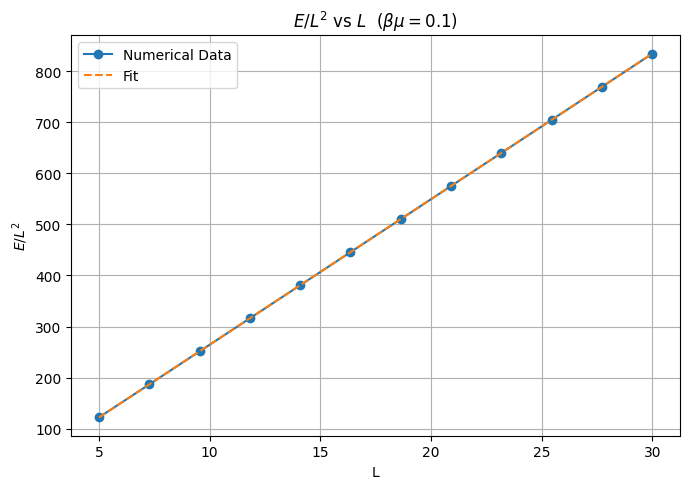

RESULTS FOR  beta*mu = 0.1
rho_E   = 2.8494476489e+01
sigma_E = -3.4474911336e+00
   L         E            E_fit         deltaE
 5.000  3.050253e+03  3.044686e+03   5.567244e+00
 7.273  9.868344e+03  9.866981e+03   1.363099e+00
 9.545  2.289311e+04  2.289809e+04  -4.978006e+00
11.818  4.413305e+04  4.414503e+04  -1.197608e+01
14.091  7.559669e+04  7.561484e+04  -1.815117e+01
16.364  1.192925e+05  1.193146e+05  -2.202333e+01
18.636  1.772291e+05  1.772512e+05  -2.211262e+01
20.909  2.514149e+05  2.514318e+05  -1.693909e+01
23.182  3.438584e+05  3.438634e+05  -5.022807e+00
25.455  4.565681e+05  4.565530e+05   1.511616e+01
27.727  5.915526e+05  5.915077e+05   4.495776e+01
30.000  7.508204e+05  7.507344e+05   8.598192e+01
max |deltaE| = 8.598192e+01


In [13]:
beta = 0.1   # beta*mu = 0.1

L = results[beta]["L"]
E = results[beta]["E"]
y = E / (L**2)

rho_E   = results[beta]["rho_E"]
sigma_E = results[beta]["sigma_E"]
E_fit   = results[beta]["E_fit"]
deltaE = results[beta]["deltaE"]

y_fit = rho_E * L + 6.0 * sigma_E

plt.figure(figsize=(7,5))
plt.plot(L, y, marker='o', linestyle='-', label="Numerical Data")
plt.plot(L, y_fit, linestyle='--', label="Fit")
plt.xlabel("L")
plt.ylabel(r"$E/L^2$")
plt.title(r"$E/L^2$ vs $L$  ($\beta\mu=0.1$)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("==============================================")
print("RESULTS FOR  beta*mu = 0.1")
print("==============================================")
print(f"rho_E   = {rho_E:.10e}")
print(f"sigma_E = {sigma_E:.10e}")
print("   L         E            E_fit         deltaE")

for Li, Ei, Efi, dEi in zip(L, E, E_fit, deltaE):
    print(f"{Li:6.3f}  {Ei:12.6e}  {Efi:12.6e}  {dEi: .6e}")

print(f"max |deltaE| = {results[beta]['deltaE_max']:.6e}")


## Discussion

At low temperature ($\beta\mu = 10$), the energy follows the expected ($L^3$) scaling of a degenerate Fermi gas with small surface corrections. The residual term ($\delta E$) remains small compared to the total energy.

At intermediate temperature ($\beta\mu = 1$), thermal smearing increases the bulk energy density and enhances finite-size deviations.

At high temperature ($\beta\mu = 0.1$), the energy becomes much larger due to increased thermal occupation of high-energy states, and the extracted bulk energy density increases by orders of magnitude.

In all cases, the numerical data are well described by the finite-size expansion ($E = \rho_E L^3 + 6\sigma_E L^2$), confirming the expected scaling behavior of a Fermi gas in a confined geometry.